## Tensorflow 설치와 기본 사용법

### 텐서플로 즉시 실행


- 함수를 바로 실행하는 명령형 프로그래밍 환경
- 나중에 실행하기 위해 계산가능한 그래프를 생성하는 대신, 계산 값을 즉시 알려주는 연산
- 이 기능은 텐서플로를 시작하고 모델을 디버깅하는 것을 더욱 쉽게 만들고, 불필요한 상용구 코드(boilerplate code) 작성을 줄여줌

### 제공하는 기능

* `직관적인 인터페이스` : 자연스러운 구조화, 작은 모델과 작은 데이터 빠르게 반복
* `손쉬운 디버깅` : 모델 검토 및 변경사항 테스트를 위한 연산 직접 호출, 에러 확인을 위한 표준 파이썬 디버깅 툴 사용
* `자연스러운 흐름 제어` : 파이썬 제어 흐름 사용하여 동적인 모델 구조 단순화

=> 즉시 실행은 대부분의 텐서플로 연산과 GPU 가속을 지원

In [1]:
import tensorflow as tf
import cProfile

In [2]:
tf.executing_eagerly()

True

In [3]:
x = [[2.]]
m = tf.matmul(x, x)
print("hello, {}".format(m))

hello, [[4.]]


### 즉시 실행 활성화


- 텐서플로 연산을 바로 평가하고, 그 결과를 파이썬에게 알려주는 방식으로 동작 변경
- `tf.Tensor` 객체는 계산 그래프에 있는 노드를 가르키는 간접 핸들(symbolic handle) 대신에 구체적인 값 참고
    - 계산 그래프가 따로 없어 `print()`나 디버거를 통해 결과 검토가 쉬움
- 텐서값 평가, 출력, 확인 : 그래디언트를 계산하는 흐름 방해 X

* 즉시 실행은 `Numpy`와 잘 작동됨
    - `tf.Tensor`를 매개변수로 사용가능
    
    
- 텐서플로 수학연산은 파이썬 객체와 Numpy 배열을 `tf.Tensor` 객체로 변환
- `tf.Tensor.numpy` 메소드는 객체 값을 Numpy ndarray로 반환함

In [8]:
a = tf.constant([[1, 2],
                 [3, 4]])
print(a)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [9]:
# 브로드캐스팅(Broadcasting) 지원
b = tf.add(a, 1)
print(b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [10]:
# 연산자 오버로딩 지원
print(a * b)

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [11]:
# NumPy값 사용
import numpy as np

c = np.multiply(a, b)
print(c)

[[ 2  6]
 [12 20]]


In [12]:
# 텐서로부터 numpy 값 얻기:
print(a.numpy())
# => [[1 2]
#     [3 4]]

[[1 2]
 [3 4]]


## 동적인 제어 흐름

* 즉시 실행의 가장 큰 이점: 모델을 실행하는 동안에도 호스트 언어의 모든 기능을 활용할 수 있다는 것. 그래서 fizzbuzz 손쉽게 작성 가능 (https://en.wikipedia.org/wiki/Fizz_buzz)

In [13]:
def fizzbuzz(max_num):
    counter = tf.constant(0)
    max_num = tf.convert_to_tensor(max_num)
    
    # 텐서값에 따른 조건절이 있고, 실행 중 그 결과 출력
    for num in range(1, max_num.numpy()+1):
        num = tf.constant(num)
        if int(num % 3) == 0 and int(num % 5) == 0:
            print('FizzBuzz')
        elif int(num % 3) == 0:
            print('Fizz')
        elif int(num % 5) == 0:
            print('Buzz')
        else:
            print(num.numpy())
        counter += 1

In [14]:
fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


## 즉시 훈련

### 그래디언트 계산


* **자동 미분** : 인공 신경망 훈련을 위한 역전파와 같은 기계학습 알고리즘 구현에 유용


* `tf.GradientTape`
    - 즉시 실행 중, 그래디언트를 계산하고 (나중에 그래디언트 계산 연산 추적에 사용)
    - 모델 훈련에 이용하기 위해 사용 가능 -> 복잡하고 반복적인 훈련에 더 유용
    - 모든 정방향(forward-pass) 연산은 "tape"에 기록
    - 특정한 `tf.GradientTape`는 오직 하나의 그래디언트만 계산 가능, 부가적인 호출은 실행 중 에러(runtime error) 발생시킴

In [15]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
    loss = w * w

grad = tape.gradient(loss, w)
print(grad)  # => tf.Tensor([[ 2.]], shape=(1, 1), dtype=float32)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


### 모델 훈련


##### (예) 표준 MNIST 손글씨 분류를 위한 다층 모델 생성
즉시 실행 환경에서 훈련가능한 그래프 생성을 위해 옵티마이저(optimizer)와 층 API를 보여줌

In [16]:
# mnist 데이터 가져오기 및 포맷 맞추기
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
     tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

In [17]:
# 모델 생성
mnist_model = tf.keras.Sequential([
   tf.keras.layers.Conv2D(16,[3,3], activation='relu',
                          input_shape=(None, None, 1)),
   tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
   tf.keras.layers.GlobalAveragePooling2D(),
   tf.keras.layers.Dense(10)
])

즉시 실행에서는 훈련을 하지 않아도 모델 사용 가능, 결과 점검도 가능

In [18]:
for images,labels in dataset.take(1):
    print("로짓: ", mnist_model(images[0:1]).numpy())

로짓:  [[ 0.07763627 -0.04346912 -0.03858145  0.05652889  0.0319109  -0.06233951
   0.08460674 -0.05094534 -0.0143687  -0.03439349]]


케라스 모델은 자체적인 훈련 메서드(fit)을 포함하고 있지만, 좀 더 수정할 필요가 있음

##### (예) 즉시 실행을 활용한 반복적인 훈련의 예

In [19]:
for images,labels in dataset.take(1):
    print("로짓: ", mnist_model(images[0:1]).numpy())

로짓:  [[ 0.04861377 -0.0289824  -0.02741379  0.03515264  0.01820234 -0.03736287
   0.04797138 -0.02933557 -0.00386143 -0.02063759]]


In [20]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

★ Note : 조건을 만족했는지 확인하기 위해, `tf.debugging`에 있는 단언문(assert) 함수를 사용하기. 이것은 즉시 실행 그래프 실행 모두 동작 !!

In [21]:
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = mnist_model(images, training=True)

        # 결과의 형태를 확인하기 위해서 단언문 추가
        tf.debugging.assert_equal(logits.shape, (32, 10))
        
        loss_value = loss_object(labels, logits)

    loss_history.append(loss_value.numpy().mean())
    grads = tape.gradient(loss_value, mnist_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [22]:
def train():
    for epoch in range(3):
        for (batch, (images, labels)) in enumerate(dataset):
            train_step(images, labels)
        print ('에포크 {} 종료'.format(epoch))

In [23]:
train()

에포크 0 종료
에포크 1 종료
에포크 2 종료


Text(0, 0.5, 'Loss [entropy]')

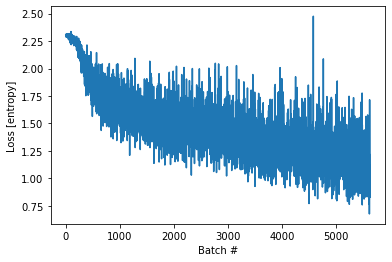

In [24]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

### 변수와 옵티마이저

* `tf.Variable` : 자동 미분을 쉽게 하기 위해서 학습동안 변경된 `tf.Tensor` 값을 저장. **모델 파라미터는 클래스 인스턴스 변수로 캡슐화 될 수 있음**

* 모델 파라미터 캡슐화 : `tf.Variable`, `tf.GradientTape`와 함께 사용 가능

##### (예) 자동 미분 캡슐화

In [25]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W = tf.Variable(5., name='weight')
        self.B = tf.Variable(10., name='bias')
    def call(self, inputs):
        return inputs * self.W + self.B

# 약 3 * x + 2개의 점으로 구성된 실험 데이터
NUM_EXAMPLES = 2000
training_inputs = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

# 최적화할 손실함수
def loss(model, inputs, targets):
    error = model(inputs) - targets
    return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, [model.W, model.B])

# 정의:
# 1. 모델
# 2. 모델 파라미터에 대한 손실 함수의 미분
# 3. 미분에 기초한 변수 업데이트 전략
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

print("초기 손실: {:.3f}".format(loss(model, training_inputs, training_outputs)))

# 반복 훈련
for i in range(300):
    grads = grad(model, training_inputs, training_outputs)
    optimizer.apply_gradients(zip(grads, [model.W, model.B]))
    if i % 20 == 0:
        print("스텝 {:03d}에서 손실: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))

print("최종 손실: {:.3f}".format(loss(model, training_inputs, training_outputs)))
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

초기 손실: 68.842
스텝 000에서 손실: 66.142
스텝 020에서 손실: 29.921
스텝 040에서 손실: 13.848
스텝 060에서 손실: 6.715
스텝 080에서 손실: 3.550
스텝 100에서 손실: 2.145
스텝 120에서 손실: 1.521
스텝 140에서 손실: 1.244
스텝 160에서 손실: 1.122
스텝 180에서 손실: 1.067
스텝 200에서 손실: 1.043
스텝 220에서 손실: 1.032
스텝 240에서 손실: 1.027
스텝 260에서 손실: 1.025
스텝 280에서 손실: 1.024
최종 손실: 1.024
W = 3.0219638347625732, B = 2.0473251342773438


## 즉시 실행에서 상태를 위한 객체 사용


텐서플로 1.* 그래프 실행 -> 프로그램 상태는 전역 컬렉션에 저장되고. 수명은 `tf.Session` 객체에 의해 관리 <br>
반면, 즉시 실행에서의 상태 객체 수명은 그와 관련된 파이썬 객체 수명에 의해 결정됨

### 변수는 객체다


* 즉시 실행에서의 변수 : 객체의 마지막 참조가 제거될 때까지 유지되고, 그 이후에 삭제

In [26]:
if tf.config.experimental.list_physical_devices("GPU"):
    with tf.device("gpu:0"):
        print("GPU 사용 가능")
        v = tf.Variable(tf.random.normal([1000, 1000]))
        v = None  # v는 더이상 GPU 메모리를 사용하지 않음

### 객체 기반의 저장

* `tf.train.Checkpoint`
    - `tf.Variable`을 체크포인트 파일로 저장하거나 체크포인트 파일에서 복구 가능
    - 모델을 저장하거나 읽어들이기 위해, 숨겨진 변수를 요구하지 않고 객체 내부 상태를 저장
    - 옵티마이저와 모델, 전역 단계 상태를 기록하려면 `tf.train.Checkpoint`에 전달하면 됨

In [30]:
x = tf.Variable(10.)
checkpoint = tf.train.Checkpoint(x=x)

In [31]:
x.assign(2.)   # 변수에 새로운 값을 할당하고 저장
checkpoint_path = './ckpt/'
checkpoint.save('./ckpt/')

'./ckpt/-1'

In [32]:
x.assign(11.)  # 저장한 후에 변수 변경

# 체크포인트로부터 값을 복구
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

print(x)  # => 2.0

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>


In [34]:
import os

# 모델 정의
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])

# 옵티마이저
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# 체크포인트
checkpoint_dir = 'path/to/model_dir'

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model)

root.save(checkpoint_prefix)
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

★ Note : 대부분의 반복 훈련 과정에서 변수는 `tf.train.Checkpoint.restore`가 호출된 이후 생성. 이 변수는 생성되자마자 복원될 것이므로, 체크포인트가 완벽히 적재되어있다는 것을 보장받을 수 있음.

### 객체 지향형 지표

* `tf.keras.metrics` : 객체로 저장
    - 새로운 데이터를 객체에 전달하여 지표 수정
    - 결과는 `tf.keras.metrics.result` 메서드를 사용해 얻음

In [35]:
m = tf.keras.metrics.Mean("loss")
m(0)
m(5)
m.result()  # => 2.5
m([8, 9])
m.result()  # => 5.5

<tf.Tensor: shape=(), dtype=float32, numpy=5.5>

### 서머리(summary)와 텐서보드

* 텐서보드 : 훈련과정에서 모델을 파악하거나 디버깅하고 최적화하기 위해 사용하는 시각화 도구


* `tf.summary`
    - 즉시 실행에서 변수의 서머리 정보를 기록하기 위해 사용
    - 예를 들어, 매 100번째 훈련마다 loss의 서머리 정보를 기록

In [36]:
logdir = "./tb/"
writer = tf.summary.create_file_writer(logdir)

with writer.as_default():  # 또는 반복 전에 writer.set_as_default()를 호출
    for i in range(1000):
        step = i + 1
        # 실제 훈련 함수로 손실을 계산
        loss = 1 - 0.001 * step
        if step % 100 == 0:
            tf.summary.scalar('손실', loss, step=step)

## 자동 미분 관련 고급편

### 동적 모델

* `tf.GradientTape` : 동적인 모델에서도 사용 가능


##### (예) 역추적 길찾기 알고리즘

In [37]:
def line_search_step(fn, init_x, rate=1.0):
    with tf.GradientTape() as tape:
        # 변수는 자동적으로 기록되지만 텐서는 사용자가 스스로 확인해야 함
        tape.watch(init_x)
        value = fn(init_x)
    grad = tape.gradient(value, init_x)
    grad_norm = tf.reduce_sum(grad * grad)
    init_value = value
    while value > init_value - rate * grad_norm:
        x = init_x - rate * grad
        value = fn(x)
        rate /= 2.0
    return x, value

### 사용자 정의 그래디언트

* 그래디언트를 재정의(override)하는 가장 쉬운 방법
* 정방향 함수 안에서 입력값 또는 출력값, 중간값과 관련된 그래디언트를 정의해야 함
* 일반적으로 연산에 대해 수치적으로(numerically) 안정된 그래디언트를 제공하기 위해 사용

##### (예) 역전파 과정 : 그래디언트 놈(norm)을 크리핑(clip)하는 가장 쉬운 방법

In [38]:
@tf.custom_gradient
def clip_gradient_by_norm(x, norm):
    y = tf.identity(x)
    def grad_fn(dresult):
        return [tf.clip_by_norm(dresult, norm), None]
    return y, grad_fn

In [40]:
def log1pexp(x):
    return tf.math.log(1 + tf.exp(x))

def grad_log1pexp(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        value = log1pexp(x)
    return tape.gradient(value, x)

In [41]:
# 그래디언트 계산은 x = 0일 때 잘 동작
grad_log1pexp(tf.constant(0.)).numpy()

0.5

In [42]:
# 그러나, x = 100일 때 수치적으로 불안정하기 때문에 실패
grad_log1pexp(tf.constant(100.)).numpy()

nan

`log1pexp` 함수
- 이론적으로 사용자 그래디언트를 활용해 간결해질 수 있음.
- 불필요한 계산을 제거함으로써, 계산을 조금 더 효율적으로 하기 위해, 정방향 경로 안에서 계산된 `tf.exp(x)` 값을 재사용함

In [43]:
@tf.custom_gradient
def log1pexp(x):
    e = tf.exp(x)
    def grad(dy):
        return dy * (1 - 1 / (1 + e))
    return tf.math.log(1 + e), grad

def grad_log1pexp(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        value = log1pexp(x)
    return tape.gradient(value, x)

In [44]:
# 전처럼, 그래디언트 계산은 x = 0일 때 잘 동작
grad_log1pexp(tf.constant(0.)).numpy()

0.5

In [45]:
# 그래디언트 계산은 x = 100일 때 역시 잘 동작
grad_log1pexp(tf.constant(100.)).numpy()

1.0

## 성능

* 즉시 실행에서 계산은 자동으로 GPU로 분배
* 만약, 계산 분배를 사용자가 제어하고 싶을 경우, 그 부분을 `tf.device('/gpu:0)` 블록(CPU도 동일)로 감싸기

In [46]:
import time

def measure(x, steps):
    # 텐서플로는 처음 사용할 때 GPU를 초기화, 시간계산에서 제외
    tf.matmul(x, x)
    start = time.time()
    for i in range(steps):
        x = tf.matmul(x, x)
  
    # tf.matmul는 행렬 곱셈을 완료하기 전에 결과를 반환할 수 있습니다
    # (예, CUDA 스트림 대기열에 연산을 추가한 후에 결과를 반환할 수 있다).
    # 아래 x.numpy() 호출은 대기열에 추가된 모든 연산이 완료될 것임을 보장합니다
    # (그리고 그 결과가 호스트 메모리에 복사될 것이고,
    # 그래서 matnul 연산시간보다는 조금 많은 연산시간이
    # 포함됩니다).
    _ = x.numpy()
    end = time.time()
    return end - start

shape = (1000, 1000)
steps = 200
print("{} 크기 행렬을 자기 자신과 {}번 곱했을 때 걸리는 시간:".format(shape, steps))

# CPU에서 실행:
with tf.device("/cpu:0"):
    print("CPU: {} 초".format(measure(tf.random.normal(shape), steps)))

# GPU에서 실행, 가능하다면:
if tf.config.experimental.list_physical_devices("GPU"):
    with tf.device("/gpu:0"):
        print("GPU: {} 초".format(measure(tf.random.normal(shape), steps)))
else:
    print("GPU: 없음")

(1000, 1000) 크기 행렬을 자기 자신과 200번 곱했을 때 걸리는 시간:
CPU: 1.5453433990478516 초
GPU: 없음


`tf.Tensor` 객체는 실제로 그 연산을 수행할 다른 디바이스로 복사 가능

In [47]:
if tf.config.experimental.list_physical_devices("GPU"):
    x = tf.random.normal([10, 10])

    x_gpu0 = x.gpu()
    x_cpu = x.cpu()

    _ = tf.matmul(x_cpu, x_cpu)    # CPU에서 실행
    _ = tf.matmul(x_gpu0, x_gpu0)  # GPU:0에서 실행

### 벤치마크

GPU에서 실행되는 ResNet50 같은 계산량 많은 모델에서, 즉시 실행 성능은 `tf.function`과 비교될 수 있음.<br> 

이러한 차이는 계산량이 작은 모델인 경우 더 커지고, 수많은 작은 연산으로 구성된 모델은 자주 반복되는 부분을 최적화하는 사례도 있음

## 함수 활용

즉시 실행이 개발과 디버깅 과정을 대화형(interactive)으로 만들어 주지만, 텐서플로 1.x 형태 그래프 실행은 학습의 분산과 성능, 운영 배포에 장점을 가지고 있음 <br>

이러한 차이를 해소하기 위해, 텐서플로 2.0에서는 `tf.function` API를 도입